In [1]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import scanpy as sc
import scvelo as scv
import random
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine
from scipy.special import kl_div

SEED = 2024
np.random.seed(SEED)
random.seed(SEED)

In [2]:
methods = {
    'Velocyto':'velocity',
    'scvelo_stochastic':'velocity',
    'scvelo_dynamical':'velocity',
    'veloAE':'velocity',
    'Dynamo_deterministic':'velocity',
    'veloVAE':'velocity',
    'UniTvelo':'velocity',
    'DeepVelo_SA':'velocity',
    'cellDancer':'velocity',
    'veloVI':'velocity',
    'LatentVelo':'velocity',
    'DeepVelo_GB':'velocity',
    'STT':'velocity',
    'TFvelo':'velocity'}

method_replacements = {
    "Velocyto": "velocyto",
    "scvelo_stochastic": "scVelo(sto)",
    "scvelo_dynamical": "scVelo(dyn)",
    "veloAE": "VeloAE",
    "Dynamo_deterministic": "dynamo",
    "veloVAE": "VeloVAE",
    "UniTvelo": "UniTVelo",
    "DeepVelo_SA": "DeepVelo(VAE)",
    "Celldancer": "cellDancer",
    "velovi": "veloVI",
    "Latentvelo": "LatentVelo",
    "DeepVelo_GB": "DeepVelo(GCN)",
    "stt": "STT",
    "multivelo": "MultiVelo",
    "phylovelo": "PhyloVelo",
    "tfvelo": "TFvelo"
}

method_palette = {
    "velocyto": "#D62728FF",
    "scVelo(sto)": "#cab2d6",
    "scVelo(dyn)": "#6a3d9a",
    "VeloAE": "#33a02c",
    "dynamo": "#FFB547FF",
    "VeloVAE": "#b2df8a",
    "UniTVelo": "#bcbd22",
    "DeepVelo(VAE)": "#1f78b4",
    "cellDancer": "#e377c2",
    "veloVI": "#ff9896",
    "LatentVelo": "#17BECFFF",
    "DeepVelo(GCN)": "#a6cee3",
    "STT": "#ff7f00",
    "MultiVelo": "#843C39FF",
    "PhyloVelo": "#E7CB94FF",
    "TFvelo": "#7B4173FF"
}

computing velocity embedding
    finished (0:00:00) --> added
    'ground_truth_velocity_cce', embedded velocity vectors (adata.obsm)
Velocyto
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_cce', embedded velocity vectors (adata.obsm)
scvelo_stochastic
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_cce', embedded velocity vectors (adata.obsm)
scvelo_dynamical
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_cce', embedded velocity vectors (adata.obsm)
veloAE
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_cce', embedded velocity vectors (adata.obsm)
Dynamo_deterministic
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_cce', embedded velocity vectors (adata.obsm)
veloVAE
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_cce', embedded velocity vectors (adata.obsm)
UniTvelo
computing velocity embedding
    finished (0:00:00)

  0%|          | 0/1756 [00:00<?, ?cells/s]

    finished (0:00:19) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_cce', embedded velocity vectors (adata.obsm)


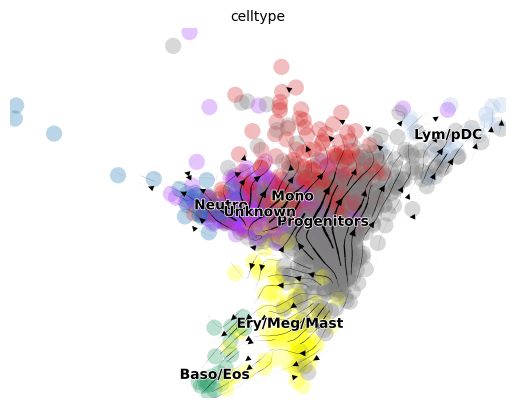

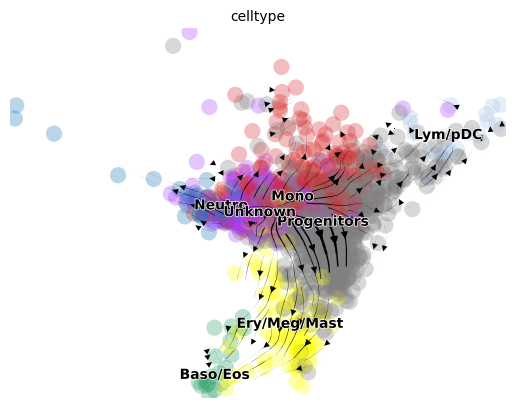

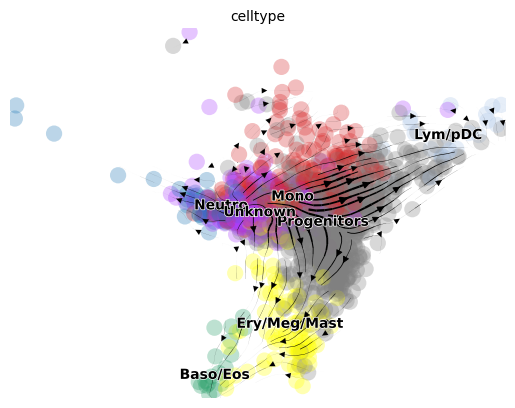

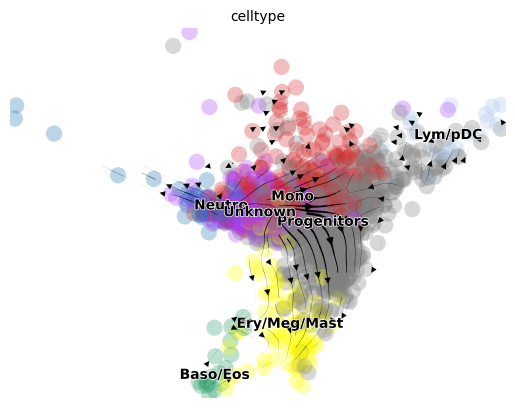

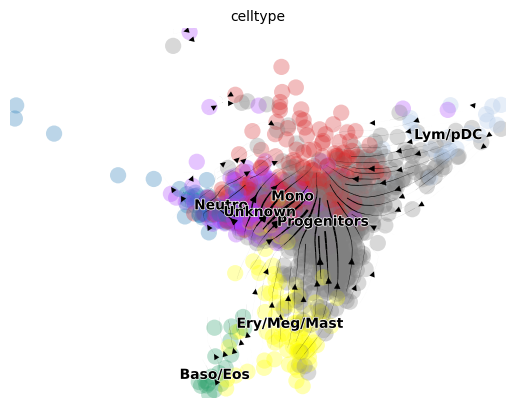

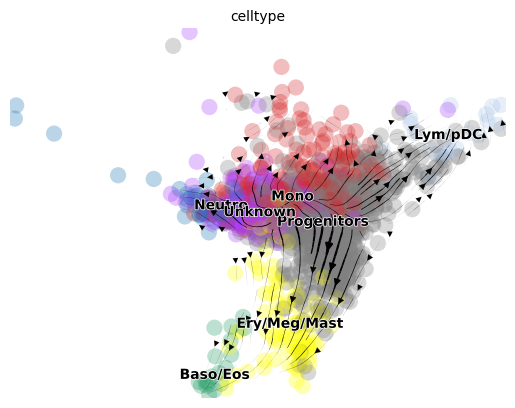

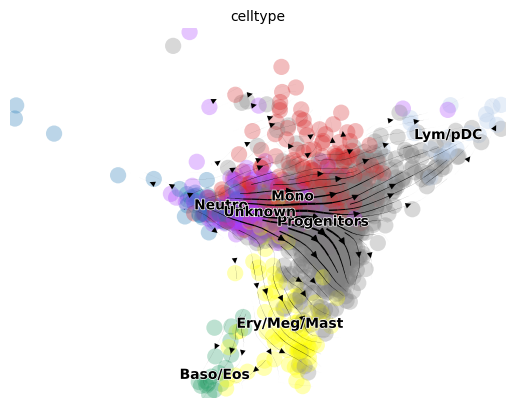

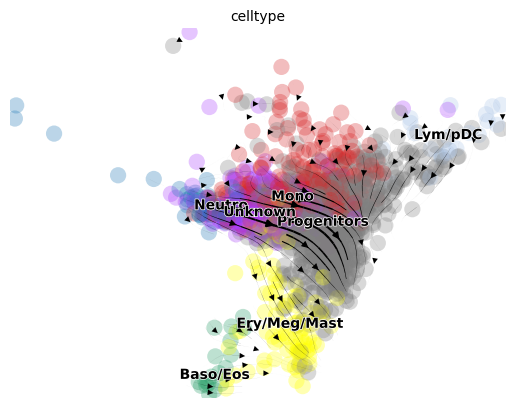

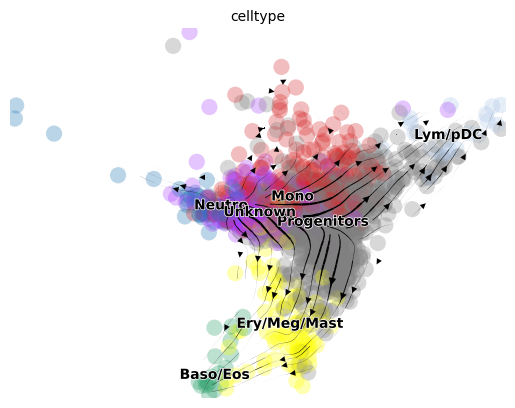

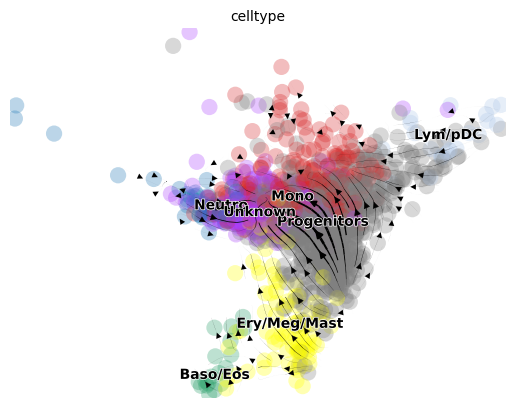

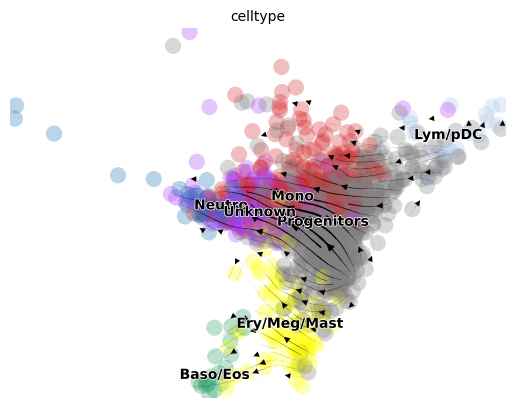

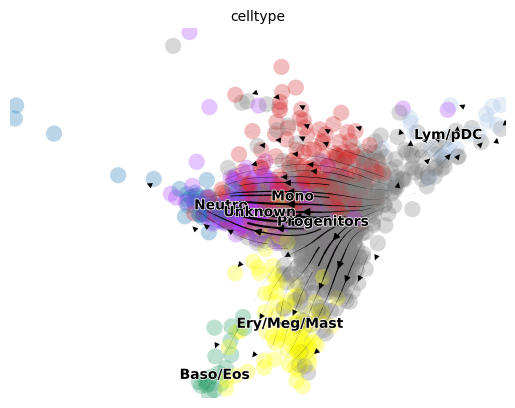

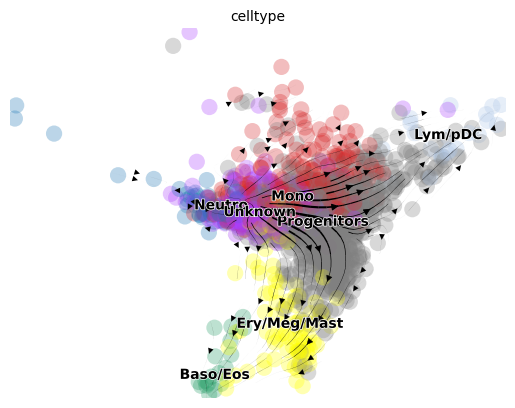

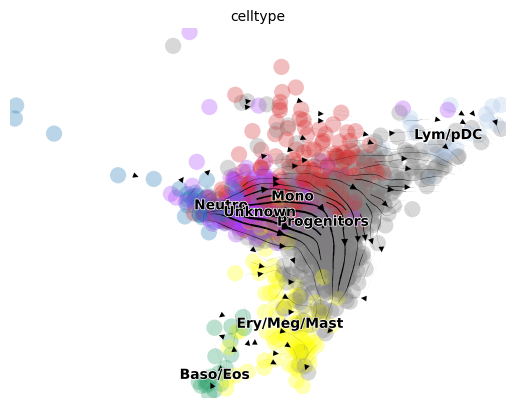

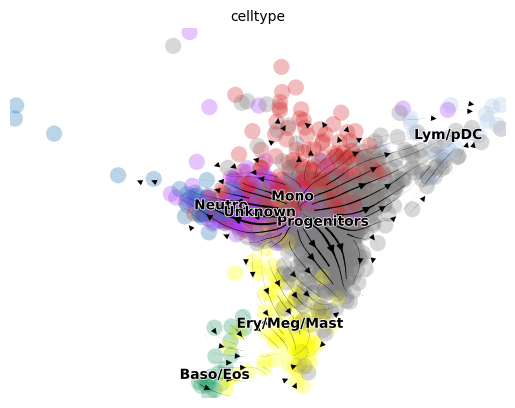

In [3]:
path = 'adata_graph/'

cell_cosine_sim_list = []
method_name_list = []

adata = sc.read_h5ad('adata_graph/LSK_lineage_cell1_ground_truth.h5ad')
adata.obs.loc[:,'celltype'] = adata.obs.loc[:,'cell_type'].tolist()
adata.obs.loc[adata.obs.cell_type.isin(["MEP","MPP","MPP/GMP"]),'celltype'] = "Progenitors"

scv.pl.velocity_embedding_stream(adata,basis= "cce",show=False,vkey = 'ground_truth_velocity',color="celltype",
                                recompute=True)

adata_gt = adata
cell1_list = adata_gt.obs.index.tolist()

for method in methods.keys():
    
    print(method)

    adata = sc.read_h5ad(path + method + '.h5ad')
    adata.obs.loc[:,'celltype'] = adata_gt.obs.loc[:,'celltype']

    if method == 'TFvelo':
        n_cells = adata.shape[0]
        expanded_scaling_y = np.expand_dims(np.array(adata.var['fit_scaling_y']),0).repeat(n_cells,axis=0)
        adata.layers['velocity'] = adata.layers['velo_hat'] / expanded_scaling_y
        scv.tl.velocity_graph(adata,vkey="velocity",n_jobs=26,basis= "cce")

    # scv.pp.neighbors(adata)
    scv.pl.velocity_embedding_stream(adata,basis= "cce",show=False,recompute=True,color="celltype",vkey = 'velocity')
    
    adata = adata[cell1_list]

    # umap cosine
    cosine_sim_cell_matrix = cosine_similarity(adata_gt.obsm['ground_truth_velocity_cce'], adata.obsm['velocity_cce'])
    cosine_sim_cell = np.diag(cosine_sim_cell_matrix)
    cell_cosine_sim_list.append(cosine_sim_cell)

    if method in method_replacements.keys():
        title_name = method_replacements[method]
    else:
        title_name = method
    method_name_list.append(title_name)

    

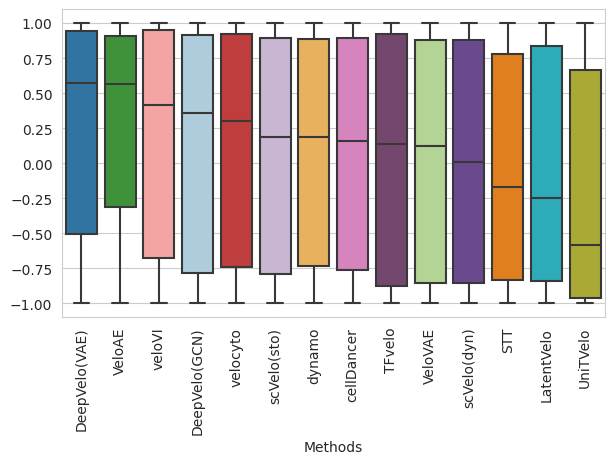

In [4]:
df = pd.DataFrame(cell_cosine_sim_list).T
df.columns = method_name_list 

index_sort = df.median().sort_values(ascending=False).index
df= df[index_sort]

plt.figure(figsize=(7,4))
sns.set_style("whitegrid")

sns.boxplot(data=df, palette=method_palette)

plt.xlabel('Methods')


ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.savefig("cosine_sim_low_dim.pdf",bbox_inches='tight')
plt.show()

df.to_csv('Clone_info.csv')